<a href="https://colab.research.google.com/github/jiakhelal/AI-powered-Railway-Track-Tampering-Detection-System/blob/main/railway_track_fault_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-72gpm4ea
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-72gpm4ea
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=43670 sha256=db074e0f0a0407fa86851f8b476d4fa7865ca4e6b70935f8278297cb43fbb4df
  Stored in directory: /tmp/pip-ephem-wheel-cache-oas5h9n6/wheels/69/29/f7/3abdb24031a22af044df15784c8a00f56b6e24f5924e33d0e8
Successfully built grad-cam


In [ ]:

# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score
import timm
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
!export KAGGLE_API_TOKEN=KGAT_7c4caa0898ccf2c990116de07f2fe504

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jiakhelal","key":"7e93eada41391eab537faf822fab8d01"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list


ref                                                     title                                           size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------  ----------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
neurocipher/heartdisease                                Heart Disease                                   3491  2025-12-11 15:29:14.327000           2114        165  1.0              
neurocipher/student-performance                         Student Performance                            49705  2025-12-12 12:06:28.973000           1261        104  1.0              
dansbecker/powerlifting-database                        powerlifting-database                        9277600  2019-04-30 21:07:41.560000          24255        349  0.5882353        
rtatman/188-million-us-wildfires                        1.88 Million US Wildfires         

In [ ]:
!kaggle datasets download -d ashikadnan/railway-track-fault-detection-dataset2fastener

Dataset URL: https://www.kaggle.com/datasets/ashikadnan/railway-track-fault-detection-dataset2fastener
License(s): copyright-authors
 99% 2.97G/2.99G [00:38<00:00, 59.5MB/s]
100% 2.99G/2.99G [00:38<00:00, 83.8MB/s]


In [ ]:
!ls

kaggle.json  railway-track-fault-detection-dataset2fastener.zip  sample_data


In [ ]:
!unzip railway-track-fault-detection-dataset2fastener.zip -d railway_fastener_data

Archive:  railway-track-fault-detection-dataset2fastener.zip
  inflating: railway_fastener_data/Dataset 2_Fastener/Test/Defective/IMG_20201114_102058.jpg  
  inflating: railway_fastener_data/Dataset 2_Fastener/Test/Defective/IMG_20201114_102122.jpg  
  inflating: railway_fastener_data/Dataset 2_Fastener/Test/Defective/IMG_20201114_102124.jpg  
  inflating: railway_fastener_data/Dataset 2_Fastener/Test/Defective/IMG_20201114_102200.jpg  
  inflating: railway_fastener_data/Dataset 2_Fastener/Test/Defective/IMG_20201114_102230.jpg  
  inflating: railway_fastener_data/Dataset 2_Fastener/Test/Defective/IMG_20201114_102334.jpg  
  inflating: railway_fastener_data/Dataset 2_Fastener/Test/Defective/IMG_20201114_102338.jpg  
  inflating: railway_fastener_data/Dataset 2_Fastener/Test/Defective/IMG_20201114_102340.jpg  
  inflating: railway_fastener_data/Dataset 2_Fastener/Test/Defective/IMG_20201114_102344.jpg  
  inflating: railway_fastener_data/Dataset 2_Fastener/Test/Defective/IMG_20201114_10

In [ ]:
!ls "railway_fastener_data/Dataset 2_Fastener"

Test  Train  Validiation


In [ ]:
!ls "railway_fastener_data/Dataset 2_Fastener/Train"

 Defective  'Non Defective'


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 8

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


train_ds = datasets.ImageFolder("/content/railway_fastener_data/Dataset 2_Fastener/Train", transform)
val_ds   = datasets.ImageFolder("/content/railway_fastener_data/Dataset 2_Fastener/Validiation", transform)
test_ds  = datasets.ImageFolder("/content/railway_fastener_data/Dataset 2_Fastener/Test", transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds, batch_size=1)

class_names = train_ds.classes
print(class_names)



['Defective', 'Non Defective']


In [ ]:
print("Train samples:", len(train_ds))
print("Val samples:", len(val_ds))
print("Test samples:", len(test_ds))


Train samples: 980
Val samples: 280
Test samples: 140


In [ ]:
images, labels = next(iter(train_loader))
print(images.shape, labels[:5])


torch.Size([8, 3, 224, 224]) tensor([0, 1, 0, 1, 0])


 Generic Training Function (USED BY ALL MODELS)

In [ ]:
def train_model(model, optimizer, epochs):
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(
            f"Epoch [{epoch+1}/{epochs}] "
            f"Train Loss: {running_loss / len(train_loader):.4f}"
        )




In [ ]:
def evaluate_model(model, name):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred, target_names=class_names))



In [ ]:
def get_davit():
    model = timm.create_model(
        "davit_small",
        pretrained=True,
        num_classes=2
    )

    # Freeze entire model first
    for p in model.parameters():
        p.requires_grad = False

    # Unfreeze last stage + head (hackathon safe)
    for name, p in model.named_parameters():
        if "stages.3" in name or "head" in name:
            p.requires_grad = True

    return model.to(device)



In [ ]:
davit_model = get_davit()                 #train davit

optimizer_davit = optim.AdamW(
    filter(lambda p: p.requires_grad, davit_model.parameters()),
    lr=3e-5,
    weight_decay=1e-4
)

train_model(davit_model, optimizer_davit, epochs=5)
evaluate_model(davit_model, "DaViT-Small")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/199M [00:00<?, ?B/s]

Epoch [1/5] Train Loss: 0.5084
Epoch [2/5] Train Loss: 0.2891
Epoch [3/5] Train Loss: 0.1590
Epoch [4/5] Train Loss: 0.0733
Epoch [5/5] Train Loss: 0.0242

DaViT-Small Accuracy: 0.9357
               precision    recall  f1-score   support

    Defective       0.94      0.93      0.94        70
Non Defective       0.93      0.94      0.94        70

     accuracy                           0.94       140
    macro avg       0.94      0.94      0.94       140
 weighted avg       0.94      0.94      0.94       140



EfficientNet-B0


In [ ]:
def get_efficientnet():
    model = timm.create_model(
        "efficientnet_b0",
        pretrained=True,
        num_classes=2
    )

    for p in model.parameters():
        p.requires_grad = False

    for p in model.classifier.parameters():
        p.requires_grad = True

    return model.to(device)



In [ ]:
eff_model = get_efficientnet()

optimizer_eff = optim.Adam(
    eff_model.parameters(),
    lr=1e-4
)

train_model(eff_model, optimizer_eff, epochs=5)
evaluate_model(eff_model, "EfficientNet-B0")


Epoch [1/5] Train Loss: 2.5285
Epoch [2/5] Train Loss: 2.0460
Epoch [3/5] Train Loss: 1.9304
Epoch [4/5] Train Loss: 1.8417
Epoch [5/5] Train Loss: 1.7317

EfficientNet-B0 Accuracy: 0.5071
               precision    recall  f1-score   support

    Defective       0.51      0.46      0.48        70
Non Defective       0.51      0.56      0.53        70

     accuracy                           0.51       140
    macro avg       0.51      0.51      0.51       140
 weighted avg       0.51      0.51      0.51       140



In [ ]:

torch.save(eff_model.state_dict(), "efficientnet_fastener.pth")


ViT-B/16

In [ ]:
def get_vit():
    model = timm.create_model(
        "vit_base_patch16_224",
        pretrained=True,
        num_classes=2
    )

    # Freeze everything
    for p in model.parameters():
        p.requires_grad = False

    # Unfreeze classifier safely
    for p in model.get_classifier().parameters():
        p.requires_grad = True

    return model.to(device)


In [ ]:
vit_model = get_vit()

optimizer_vit = optim.AdamW(
    filter(lambda p: p.requires_grad, vit_model.parameters()),
    lr=1e-4
)

train_model(vit_model, optimizer_vit, epochs=5)
evaluate_model(vit_model, "ViT-B/16")


Epoch [1/5] Train Loss: 0.5826
Epoch [2/5] Train Loss: 0.4414
Epoch [3/5] Train Loss: 0.3899
Epoch [4/5] Train Loss: 0.3560
Epoch [5/5] Train Loss: 0.3295

ViT-B/16 Accuracy: 0.8357
               precision    recall  f1-score   support

    Defective       0.78      0.94      0.85        70
Non Defective       0.93      0.73      0.82        70

     accuracy                           0.84       140
    macro avg       0.85      0.84      0.83       140
 weighted avg       0.85      0.84      0.83       140



In [ ]:
torch.save(vit_model.state_dict(), "vit_fastener.pth")

In [ ]:
import pandas as pd

data = [
    ["DaViT-Small", 0.94, 0.94, 0.93, 0.94, 0.93, 0.94, 0.94, 0.94, 0.94],
    ["ViT-B/16", 0.84, 0.78, 0.94, 0.85, 0.93, 0.73, 0.82, 0.83, 0.83],
    ["EfficientNet-B0", 0.51, 0.51, 0.46, 0.48, 0.51, 0.56, 0.53, 0.51, 0.51],
]

columns = [
    "Model", "Accuracy",
    "Defective Precision", "Defective Recall", "Defective F1",
    "Non-Defective Precision", "Non-Defective Recall", "Non-Defective F1",
    "Macro F1", "Weighted F1"
]

df = pd.DataFrame(data, columns=columns)

def highlight_davit(row):
    if row["Model"] == "DaViT-Small":
        return ["background-color: blue"] * len(row)
    else:
        return [""] * len(row)

df.style.apply(highlight_davit, axis=1)



,Model,Accuracy,Defective Precision,Defective Recall,Defective F1,Non-Defective Precision,Non-Defective Recall,Non-Defective F1,Macro F1,Weighted F1
0,DaViT-Small,0.940000,0.940000,0.930000,0.940000,0.930000,0.940000,0.940000,0.940000,0.940000
1,ViT-B/16,0.840000,0.780000,0.940000,0.850000,0.930000,0.730000,0.820000,0.830000,0.830000
2,EfficientNet-B0,0.510000,0.510000,0.460000,0.480000,0.510000,0.560000,0.530000,0.510000,0.510000


In [ ]:
from google.colab import files
files.download("davit_fastener.pth")


In [ ]:
import torch
import timm
import cv2
import numpy as np
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate model architecture
davit_model = timm.create_model(
    "davit_small",
    pretrained=False,
    num_classes=2
)

# Load weights
state_dict = torch.load("/content/drive/MyDrive/railway_models/davit_fastener.pth", map_location=device)
davit_model.load_state_dict(state_dict)
davit_model.to(device)
davit_model.eval()

class_names = ["Defective", "Non Defective"]


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
davit_model = timm.create_model(
    "davit_small",
    pretrained=False,
    num_classes=2
)

davit_model.load_state_dict(
    torch.load("/content/drive/MyDrive/railway_models/davit_fastener.pth", map_location=device)
)

davit_model.to(device)
davit_model.eval()

class_names = ["Defective", "Non Defective"]


In [ ]:
def predict_with_confidence(model, img_path):
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img_rgb, (224, 224))

    input_tensor = transform(
        transforms.ToPILImage()(img_resized)
    ).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1)
        conf, pred = torch.max(probs, dim=1)

    return img_resized, pred.item(), conf.item(), input_tensor


In [ ]:
target_layers = [davit_model.stages[3]]



In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def generate_gradcam(model, input_tensor, rgb_image, target_class=None):
    cam = GradCAM(
        model=model,
        target_layers=target_layers
    )

    if target_class is not None:
        targets = [ClassifierOutputTarget(target_class)]
    else:
        targets = None

    grayscale_cam = cam(
        input_tensor=input_tensor,
        targets=targets
    )[0]   # (224, 224)

    cam_image = show_cam_on_image(
        rgb_image.astype("float32") / 255.0,
        grayscale_cam,
        use_rgb=True
    )

    return grayscale_cam, cam_image



Confidence score tells how sure the model is.
Severity score tells how bad the defect is.


Prediction : Defective
Confidence : 0.61
⚠️ Low confidence – manual inspection recommended
Severity Score : 0.20
Severity Level : Low Severity 🟢


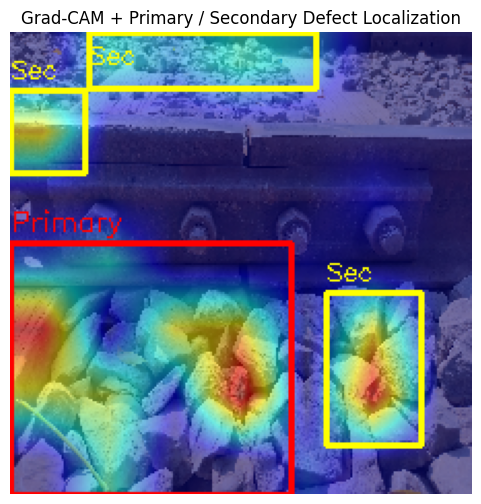

In [ ]:
# ===============================
# IMAGE PATH
# ===============================
img_path = "/content/railway_fastener_data/Dataset 2_Fastener/Test/Non Defective/IMG_20201114_101756.jpg"

# ===============================
# PREDICTION + CONFIDENCE
# ===============================
img_resized, pred, confidence, input_tensor = predict_with_confidence(
    davit_model, img_path
)

print(f"Prediction : {class_names[pred]}")
print(f"Confidence : {confidence:.2f}")

if confidence < 0.7:
    print("⚠️ Low confidence – manual inspection recommended")

# ===============================
# DECIDE GRAD-CAM
# ===============================
show_cam = (pred == class_names.index("Defective")) or (confidence < 0.7)

if show_cam:
    # ===============================
    # GRAD-CAM
    # ===============================
    grayscale_cam, cam_img = generate_gradcam(
        davit_model,
        input_tensor,
        img_resized,
        target_class=pred
    )

    # ===============================
    # SEVERITY SCORE
    # ===============================
    severity = grayscale_cam.sum() / grayscale_cam.size

    if severity > 0.6:
        severity_level = "High Severity 🔴"
    elif severity > 0.3:
        severity_level = "Medium Severity 🟠"
    else:
        severity_level = "Low Severity 🟢"

    print(f"Severity Score : {severity:.2f}")
    print(f"Severity Level : {severity_level}")

    # ===============================
    # CAM → BINARY MASK
    # ===============================
    cam_uint8 = np.uint8(255 * grayscale_cam)

    _, thresh = cv2.threshold(
        cam_uint8, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    kernel = np.ones((5,5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(
        thresh,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    # ===============================
    # FILTER CONTOURS
    # ===============================
    valid_contours = [c for c in contours if cv2.contourArea(c) > 200]

    boxed_img = cam_img.copy()

    if len(valid_contours) > 0:
        # Sort by area (largest first)
        valid_contours = sorted(
            valid_contours,
            key=cv2.contourArea,
            reverse=True
        )

        # ===============================
        # PRIMARY DEFECT (RED)
        # ===============================
        primary = valid_contours[0]
        x, y, w, h = cv2.boundingRect(primary)

        cv2.rectangle(
            boxed_img,
            (x, y),
            (x + w, y + h),
            (255, 0, 0),
            2
        )
        cv2.putText(
            boxed_img,
            "Primary",
            (x, max(y - 6, 15)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.45,
            (255, 0, 0),
            1
        )

        # ===============================
        # ALL SECONDARY DEFECTS (YELLOW)
        # ===============================
        for cnt in valid_contours[1:]:
            x, y, w, h = cv2.boundingRect(cnt)

            cv2.rectangle(
                boxed_img,
                (x, y),
                (x + w, y + h),
                (255, 255, 0),
                2
            )

            # ---- SAFE LABEL PLACEMENT ----
            label = "Sec"
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.4
            thickness = 1

            (text_w, text_h), _ = cv2.getTextSize(
                label, font, font_scale, thickness
            )

            label_x = x
            label_y = y - 6

            # If label goes above image
            if label_y - text_h < 0:
                label_y = y + text_h + 6

            # If label goes outside right
            if label_x + text_w > boxed_img.shape[1]:
                label_x = boxed_img.shape[1] - text_w - 2

            # If label goes outside left
            if label_x < 0:
                label_x = 2

            cv2.putText(
                boxed_img,
                label,
                (label_x, label_y),
                font,
                font_scale,
                (255, 255, 0),
                thickness
            )

    # ===============================
    # DISPLAY OUTPUT
    # ===============================
    plt.figure(figsize=(6,6))
    plt.imshow(boxed_img)
    plt.title("Grad-CAM + Primary / Secondary Defect Localization")
    plt.axis("off")
    plt.show()

else:
    print("✅ High-confidence normal case – Grad-CAM skipped")


In [ ]:
!ls

sample_data


In [ ]:
MODEL_PATH = "/content/drive/MyDrive/railway_models/davit_fastener.pth"

# create folder if not exists
import os
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

torch.save(davit_model.state_dict(), MODEL_PATH)
print("Model saved to Google Drive!")


Model saved to Google Drive!


In [ ]:
import torch
import numpy as np
import cv2

def attention_rollout(model, input_tensor, discard_ratio=0.9):
    """
    Attention Rollout for ViT / DaViT
    """
    attentions = []

    def get_attention(module, input, output):
        # output shape: [B, heads, tokens, tokens]
        attentions.append(output.detach())

    hooks = []
    for name, module in model.named_modules():
        if "attn" in name.lower():
            hooks.append(module.register_forward_hook(get_attention))

    # Forward pass
    with torch.no_grad():
        _ = model(input_tensor)

    for h in hooks:
        h.remove()

    # Average heads & rollout
    rollout = None
    for attn in attentions:
        attn = attn.mean(dim=1)  # avg heads
        attn = attn.squeeze(0)

        if rollout is None:
            rollout = attn
        else:
            rollout = attn @ rollout

    # Remove CLS token
    rollout = rollout[0, 1:]

    rollout = rollout / rollout.max()
    return rollout.cpu().numpy()


In [ ]:
import torch
import timm

# 1️⃣ Create the model architecture (SAME as training)
model = timm.create_model(
    "davit_tiny.msft_in1k",
    pretrained=False,
    num_classes=2
)

# 2️⃣ Load the old trained weights
model.load_state_dict(
    torch.load("/content/drive/MyDrive/railway_models/davit_fastener.pth", map_location="cpu"),
    strict=False
)

print("✅ Old model loaded")

# 3️⃣ SAVE SAFELY (THIS IS THE KEY STEP)
torch.save(model.state_dict(), "/content/drive/MyDrive/railway_models/davit_fastener_state_dict.pth")

print("✅ Safe state_dict saved")



✅ Old model loaded
✅ Safe state_dict saved
